In [227]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mpld3
import os
import plotly.express as px
import plotly.graph_objects as go



In [228]:


#Just supressing some warnings
warnings.filterwarnings("ignore", category=FutureWarning)


DB_PATH = "../data/database.db"

# Step 1: Load and expand genres from SQLite
def load_movies_with_genres(db_path):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql("SELECT * FROM movies", conn)
    conn.close()
    
    # Parse JSON string into lists
    df['genres'] = df['genres'].apply(json.loads)

    # Explode genres into separate rows for analysis
    df_exploded = df.explode('genres')
    
    return df, df_exploded

df, df_exploded = load_movies_with_genres(DB_PATH)



In [229]:
# Step 2: Count of Genres
genre_counts = df_exploded['genres'].value_counts()

# Create plotly figure
fig = px.bar(
    x=genre_counts.values,
    y=genre_counts.index,
    orientation='h',
    labels={'x': 'Number of Movies', 'y': 'Genre'},
    title='🎬 Genre Counts in Top 75 Movies from 2020–2024',
)

# Improve layout
fig.update_layout(
    yaxis=dict(autorange="reversed"),  # Highest at top
    height=600
)

# fig.show()

# Save to HTML
fig.write_html("../docs/plots/genre_counts.html")



In [230]:

# Step 3: Average rating per genre (top 10)
genre_avg_rating = (
    df_exploded.groupby('genres')['vote_average']
    .mean()
    .sort_values(ascending=False)
)

# Create Plotly bar chart
fig = px.bar(
    x=genre_avg_rating.values,
    y=genre_avg_rating.index,
    orientation='h',
    labels={'x': 'Average Rating', 'y': 'Genre'},
    title='⭐ Genres by Average Rating (2020–2024)',
)

# Layout tweaks
fig.update_layout(
    xaxis_range=[6, 8.5],
    yaxis=dict(autorange='reversed'),
    height=500
)

# Save to HTML
fig.write_html("../docs/plots/genre_avg_rating.html")


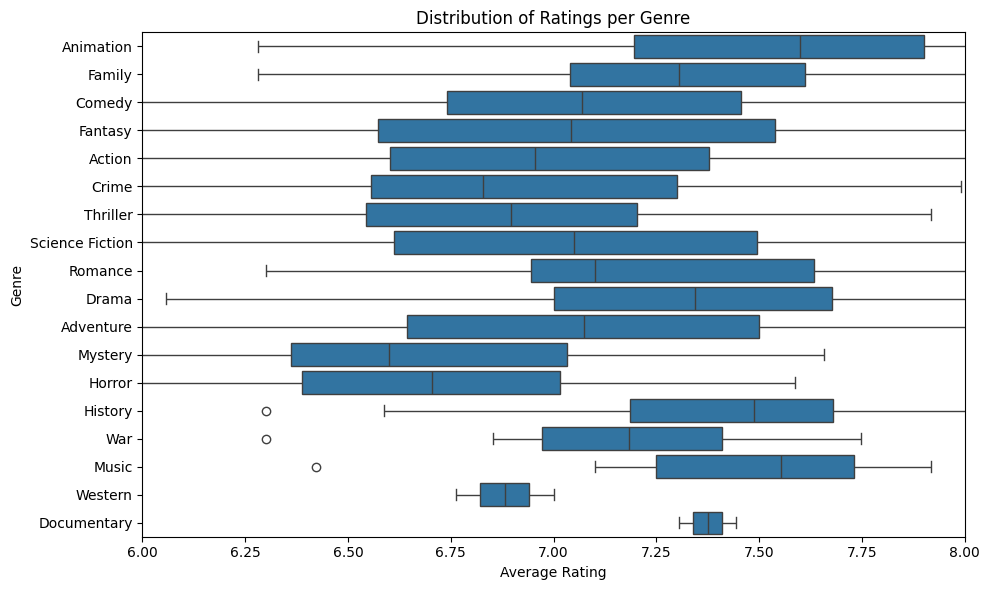

In [231]:
# Step 3: Boxplot of vote_average per genre
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exploded, x='vote_average', y='genres')

plt.title("Distribution of Ratings per Genre")
plt.xlabel("Average Rating")
plt.xlim(6, 8)  # Limit x-axis from 6 to 8
plt.ylabel("Genre")

plt.tight_layout()
plt.show()


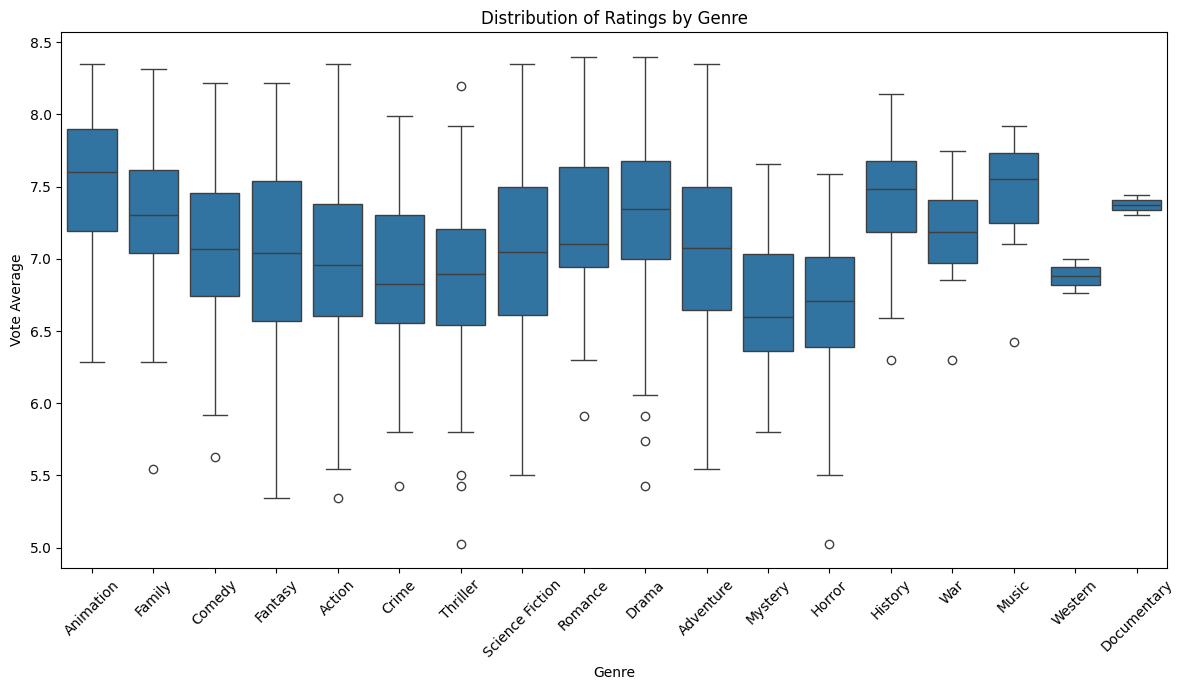

In [232]:
# Step 4: Box plot of vote_average by top genres
top_genres = genre_counts.index.tolist()
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
            x='genres', y='vote_average')
plt.title("Distribution of Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Vote Average")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


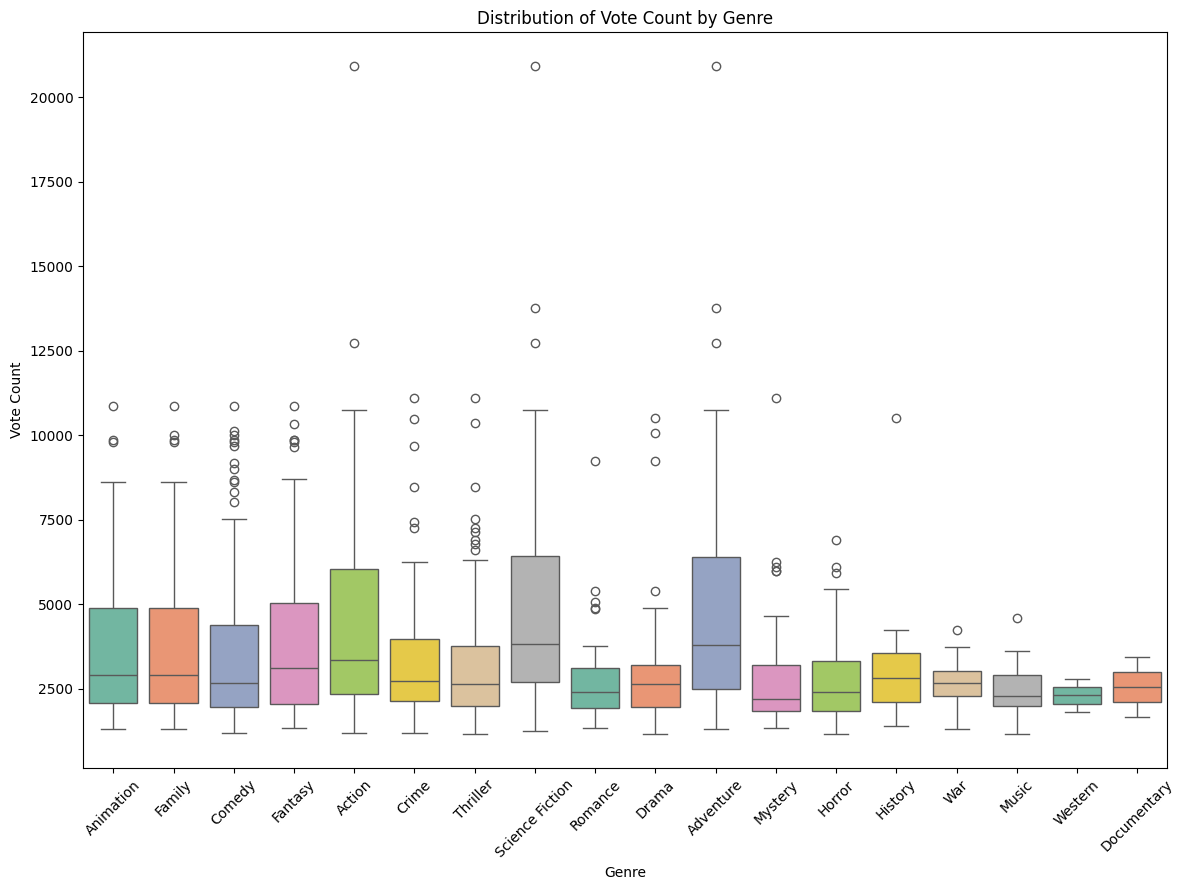

In [233]:
plt.figure(figsize=(12, 9))
sns.boxplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
            x='genres', y='vote_count', palette='Set2')
# plt.yscale('log')  # Removed log scale
plt.title("Distribution of Vote Count by Genre")
plt.xlabel("Genre")
plt.ylabel("Vote Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [234]:
# Compute genre diversity per year
genre_diversity = df.explode("genres").groupby("year")["genres"].nunique().reset_index()
genre_diversity.columns = ["year", "unique_genres"]

# Create plotly bar chart
fig = px.bar(
    genre_diversity,
    x="year",
    y="unique_genres",
    text="unique_genres",
    labels={"year": "Year", "unique_genres": "Unique Genres"},
    title="🎨 Genre Diversity Over Time (2020–2024)",
)

# Layout tweaks to simulate subtitle
fig.update_layout(
    height=500,
    title={
        "text": "🎨 Genre Diversity Over Time (2020–2024)<br><sup style='color:gray;'>↓ Fewer genres represented each year among top 75 movies</sup>",
        "x": 0.5,
        "xanchor": "center"
    },
    yaxis=dict(tickmode="linear", tick0=0, dtick=1)
)

# Save to HTML
fig.write_html("../docs/plots/genre_diversity.html")


In [237]:
counts_per_bin = df['vote_count_bin'].value_counts().sort_index()
print(counts_per_bin)


vote_count_bin
1000-2000     94
2000-3000    119
3000-4000     62
4000-5000     29
5000-6000     14
>6000         57
Name: count, dtype: int64


In [251]:

# Define new bins and labels
bins = [1000, 2500, 4000, 6000, 8000, float('inf')]
bin_labels = ['1000-2500', '2500-4000', '4000-6000', '6000-8000', ">8000"]

# Bin vote counts
df['vote_count_bin'] = pd.cut(df['vote_count'], bins=bins, labels=bin_labels, include_lowest=True)

# Create interactive box plot
fig = px.box(
    df,
    x="vote_count_bin",
    y="vote_average",
    labels={"vote_count_bin": "Vote Count Range", "vote_average": "Average Rating"},
    title="🎬 Distribution of Ratings by Vote Count Bins",
    category_orders={"vote_count_bin": bin_labels}  
)

fig.update_layout(
    xaxis_title="Vote Count Range",
    yaxis_title="Average Rating",
    height=500,
)

# Save to HTML
fig.write_html("../docs/plots/ratings_by_vote_count.html")


In [239]:
print(df['vote_count_bin'].value_counts().sort_index())


vote_count_bin
1000-2500    154
2500-4000    121
4000-6000     43
6000-8000     27
>8000         30
Name: count, dtype: int64


In [249]:
# Define bins and labels
bins = [1000, 2500, 4000, 5500, 7000, float('inf')]
bin_labels = ['1000-2500', '2500-4000', '4000-5500', '5500-7000', '>7000']

# Bin vote counts
df['vote_count_bin'] = pd.cut(df['vote_count'],
                              bins=bins,
                              labels=bin_labels,
                              include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df.groupby('vote_count_bin')['vote_average'].mean().reindex(bin_labels)

# Count number of movies per bin
movie_counts_per_bin = df['vote_count_bin'].value_counts().reindex(bin_labels).fillna(0)

# Create figure with two y-axes
fig = go.Figure()

# Add line for average rating
fig.add_trace(go.Scatter(
    x=bin_labels,
    y=avg_rating_per_bin.values,
    name='Average Rating',
    mode='lines+markers',
    marker=dict(color='blue')
))

# Layout customization with y-axis range from 6.5 to 8
fig.update_layout(
    title="🎬 Average Rating and Movie Counts by Vote Count Range",
    xaxis=dict(title="Vote Count Range"),
    yaxis=dict(
        title="Average Rating",
        range=[6.5, 8],  # <-- updated range
        tickmode='linear',
        dtick=0.5
    ),
    yaxis2=dict(
        title="Movie Count",
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99),
    height=500
)

# Save to HTML
fig.write_html("../docs/plots/rating_and_count_by_vote.html")


## Hidden Gems


In [241]:
# thresholds
high_rating_threshold = 7.5
low_vote_threshold = 2000

# ---- 1. Filter hidden gems (non-exploded, so each movie is unique) ----
hidden_gems_full = df[
    (df["vote_average"] >= high_rating_threshold) &
    (df["vote_count"] < low_vote_threshold)
].copy()

# Convert list of genres to a readable string
hidden_gems_full["genres_str"] = hidden_gems_full["genres"].apply(
    lambda g: ", ".join(g) if isinstance(g, (list, tuple)) else str(g)
)

# ---- 2. Exploded for per-genre filtering ----
df_exploded = df.explode("genres")
hidden_gems_exploded = df_exploded[
    (df_exploded["vote_average"] >= high_rating_threshold) &
    (df_exploded["vote_count"] < low_vote_threshold)
]

# ---- 3. Genres with at least 3 hidden gems ----
valid_genres = hidden_gems_exploded["genres"].value_counts()
valid_genres = valid_genres[valid_genres >= 3].index.tolist()
valid_genres = sorted(valid_genres)

# ---- 4. Build tables ----
tables_by_genre = {}

# "All" table: unique movies only, sorted by rating
tables_by_genre["All"] = hidden_gems_full.sort_values("vote_average", ascending=False)[
    ["title", "genres_str", "vote_average", "vote_count"]
]

# Per-genre tables: top 10 per genre, sorted by rating
for genre in valid_genres:
    top_gems = (
        hidden_gems_exploded[hidden_gems_exploded["genres"] == genre]
        .sort_values("vote_average", ascending=False)
        .drop_duplicates(subset="title")  # just in case
        .head(10)
    )
    # Add genres_str column for consistency
    top_gems = top_gems.assign(
        genres_str=top_gems["genres"].astype(str)
    )
    tables_by_genre[genre] = top_gems[["title", "genres_str", "vote_average", "vote_count"]]

# ---- 5. Convert to HTML (hidden divs for each genre) ----
genre_tables_html = ""
for genre, table in tables_by_genre.items():
    table_display = table.copy()
    table_display["vote_average"] = table_display["vote_average"].round(2)

    # Rename columns for clean display
    table_display = table_display.rename(columns={
        "title": "Title",
        "genres_str": "Genres",
        "vote_average": "Rating",
        "vote_count": "Votes"
    })

    table_html = table_display.to_html(
        index=False,
        justify="center",
        border=1,
        classes="genre-table",
        table_id=f"table-{genre}"
    )

    genre_tables_html += f"""
    <div class="table-container" id="container-{genre}" style="display:none">
      {table_html}
    </div>
    """
# ---- 6. Full HTML with dropdown + JS ----
full_html = f"""
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>Hidden Gems by Genre</title>
  <style>
    body {{
      font-family: Arial, sans-serif;
      max-width: 900px;
      margin: 40px auto;
      line-height: 1.6;
      padding: 0 20px;
      background-color: #fdfdfd;
      color: #333;
    }}
    select {{
      font-size: 16px;
      padding: 6px 10px;
      margin-bottom: 20px;
    }}
    table {{
      border-collapse: collapse;
      width: 100%;
      margin-bottom: 40px;
    }}
    th, td {{
      border: 1px solid #ccc;
      padding: 6px 10px;
      text-align: center;
    }}
    th {{
      background-color: #f0f0f0;
    }}
  </style>
</head>
<body>
  <h1>🎯 Hidden Gems by Genre</h1>

  <label for="genreSelect"><strong>Select Genre:</strong></label>
  <select id="genreSelect" onchange="showTable()">
    <option value="All">All</option>
    {''.join([f'<option value="{g}">{g}</option>' for g in valid_genres])}
  </select>

  {genre_tables_html}

  <script>
    function showTable() {{
      var select = document.getElementById("genreSelect");
      var value = select.value;
      var containers = document.getElementsByClassName("table-container");
      for (var i = 0; i < containers.length; i++) {{
        containers[i].style.display = "none";
      }}
      var active = document.getElementById("container-" + value);
      if (active) {{
        active.style.display = "block";
      }}
    }}
    // Show "All" by default
    document.getElementById("genreSelect").value = "All";
    showTable();
  </script>
</body>
</html>
"""

# ---- 7. Save HTML ----
with open("../docs/plots/hidden_gems_table.html", "w", encoding="utf-8") as f:
    f.write(full_html)

print("✅ Saved docs/plots/hidden_gems_table.html (unique movies in 'All', sorted by rating)")


✅ Saved docs/plots/hidden_gems_table.html (unique movies in 'All', sorted by rating)
